# Setup

In [25]:
pip install -r ../../requirements.txt

Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [26]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [27]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [29]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

In [30]:
config = json.load(open("./configs/ext_mnn_em.json"))

# Loading data

In [31]:
from data_loader.abo import ABO

In [32]:
data = ABO(path=config["data"]["path"],
           download=True,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=True,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'description2', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Performing random deletion...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,description2,path,product_type,label
0,"solimo plastic water bottle set, 1 litre, set ...",(renewed) amazon brand - solimo plastic water ...,52/52acaec1.jpg,BOTTLE,1
1,ceramicstrathwood granite finish tall bird bath,b000bixapsstrathwood granite finish tall bird ...,bf/bf3991c4.jpg,OUTDOOR_LIVING,1
2,mobile coverb07tcwpvk1amazon brand - solimo de...,mobile coverb07tcwpvk1amazon brand - solimo de...,4c/4c5216a9.jpg,CELLULAR_PHONE_CASE,1
3,"free of dyes, triclosan and phthalatesamazon b...","free of dyes, triclosan and phthalatesb07zhz9c...",2f/2f7953cd.jpg,HEALTH_PERSONAL_CARE,1
4,"b074h6mcjs365 everyday value, organic colby ja...",charcuterie and commodity cheese commodity che...,26/26b24d55.jpg,DAIRY_BASED_CHEESE,1
...,...,...,...,...,...
141550,b0853xcvqkamazon brand - solimo designer lady ...,cellphonecover,e3/e3a0e881.jpg,CELLULAR_PHONE_CASE,1
141551,amazon brand - solimo designer queen on red gl...,mobile coverb07j26kwvs,95/95210242.jpg,STRING_LIGHT,0
141552,b0857lj9tlamazon brand - solimo designer sky p...,b0857lj9tl,76/76c8119c.jpg,CELLULAR_PHONE_CASE,1
141553,samsung galaxy m31 mobile case,samsung galaxy m31 mobile caseb08511dw3qamazon...,8f/8fe081aa.jpg,CELLULAR_PHONE_CASE,1


In [33]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
text2 = data["description2"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [34]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(141555, 1014)

In [35]:
text2 = tk.tokenize(text2)
text2.shape

(141555, 1014)

## Create embedding weights

In [36]:
weights = tk.create_embedding_weights()
weights.shape

(66, 65)

# Image processing

## Load image model

In [37]:
from utils.img_processing import load_img_model, create_embeddings_from

In [38]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [39]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=2048)

Found 141555 validated image filenames.


2023-05-31 04:32:38.810640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8901
2023-05-31 04:32:39.653433: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [40]:
img.shape

(141555, 576)

# Save embeddings

In [41]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/{img_model.name}")

In [42]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
np.save(f"{save_path}/text2.npy", text2)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [43]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,description2,path,product_type,label
0,"solimo plastic water bottle set, 1 litre, set ...",(renewed) amazon brand - solimo plastic water ...,52/52acaec1.jpg,BOTTLE,1
1,ceramicstrathwood granite finish tall bird bath,b000bixapsstrathwood granite finish tall bird ...,bf/bf3991c4.jpg,OUTDOOR_LIVING,1
2,mobile coverb07tcwpvk1amazon brand - solimo de...,mobile coverb07tcwpvk1amazon brand - solimo de...,4c/4c5216a9.jpg,CELLULAR_PHONE_CASE,1
3,"free of dyes, triclosan and phthalatesamazon b...","free of dyes, triclosan and phthalatesb07zhz9c...",2f/2f7953cd.jpg,HEALTH_PERSONAL_CARE,1
4,"b074h6mcjs365 everyday value, organic colby ja...",charcuterie and commodity cheese commodity che...,26/26b24d55.jpg,DAIRY_BASED_CHEESE,1
...,...,...,...,...,...
141550,b0853xcvqkamazon brand - solimo designer lady ...,cellphonecover,e3/e3a0e881.jpg,CELLULAR_PHONE_CASE,1
141551,amazon brand - solimo designer queen on red gl...,mobile coverb07j26kwvs,95/95210242.jpg,STRING_LIGHT,0
141552,b0857lj9tlamazon brand - solimo designer sky p...,b0857lj9tl,76/76c8119c.jpg,CELLULAR_PHONE_CASE,1
141553,samsung galaxy m31 mobile case,samsung galaxy m31 mobile caseb08511dw3qamazon...,8f/8fe081aa.jpg,CELLULAR_PHONE_CASE,1


In [44]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(141555, 576)

In [45]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(141555, 1014)

In [46]:
text2 = np.load(f"{save_path}/text2.npy", allow_pickle=True)
text2.shape

(141555, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [47]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [48]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [51]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

text2_train = text2[train.index]
text2_test = text2[test.index]

# Save Char CNN config

In [52]:
from models.char_cnn_zhang import CharCNNZhang

In [53]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [54]:
char_cnn = CharCNNZhang(**char_cnn_config)
char_cnn.model

# Build Extended MNN-EM Model

![](../../assets/images/Extended_MNN_EM.png)

In [55]:
from models.mnn_em import ExtendedMNNEM
from utils.metrics import create_metrics

In [56]:
head_1_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_1_fc_layers"],
    "extended": True,
}

In [57]:
head_2_config = {
    "img_input_size": config["model"]["img_1_fc_layers"][-1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["combined_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_2_fc_layers"],
    "extended": False,
}

In [58]:
ext_mnn_em = ExtendedMNNEM(
    head_1_config=head_1_config,
    head_2_config=head_2_config,
    char_cnn=char_cnn.model,
    combined_fc_layers=config["model"]["combined_2_fc_layers"],
    learning_rate=config["model"]["training"]["learning_rate"],
    metrics=create_metrics(config["model"]["training"]["metrics"]))

In [59]:
ext_mnn_em.model.summary(expand_nested=True)

Model: "Extended_MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 1024)         16119234    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Image_Input_Head_Outer (InputL  [(None, 576)]     0           []                  

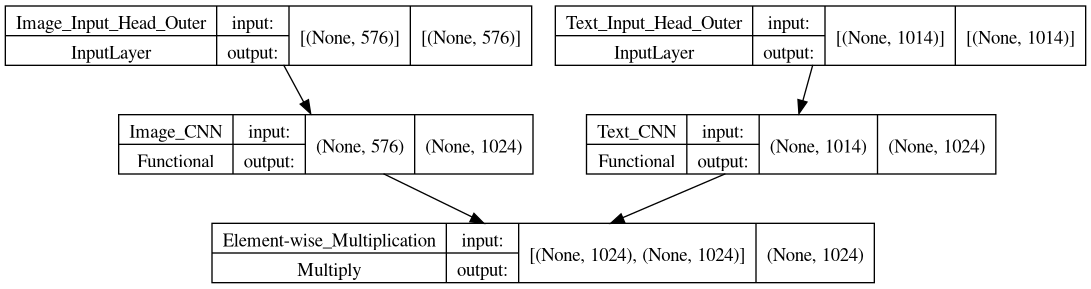

In [60]:
# "Head"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

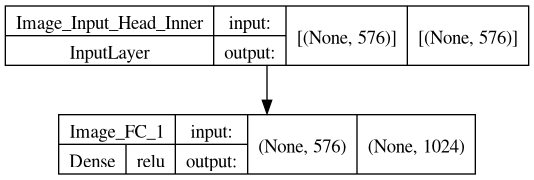

In [61]:
# Image CNN

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

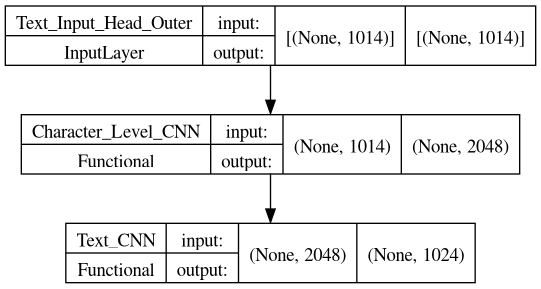

In [62]:
# Text CNN (outer)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

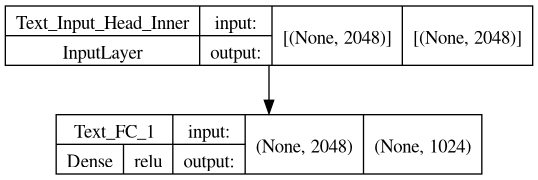

In [63]:
# Text CNN (inner)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3].layers[-1],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

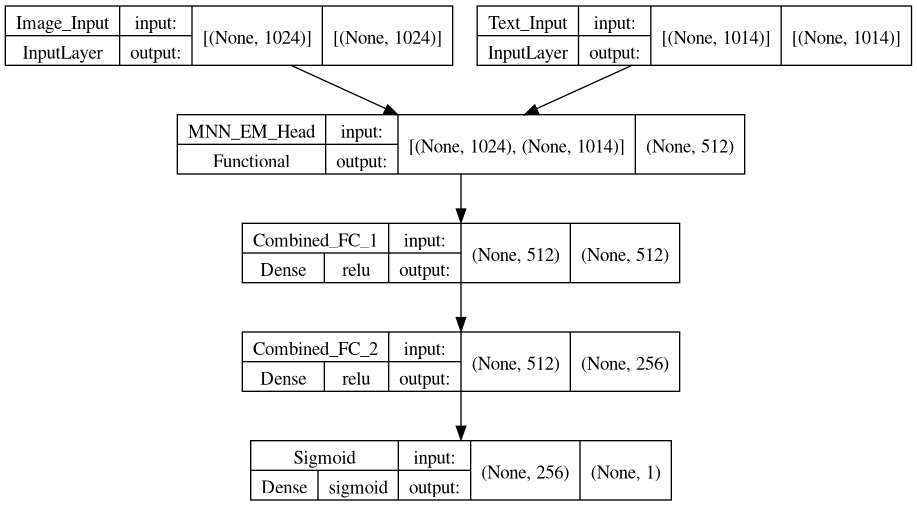

In [64]:
# "Tail"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[4],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

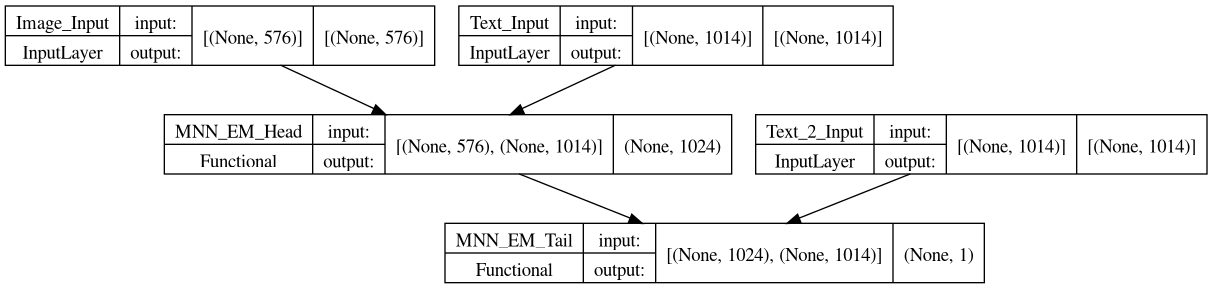

In [65]:
# Full model

tf.keras.utils.plot_model(ext_mnn_em.model,
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [66]:
from utils.metrics import create_callbacks

In [67]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [68]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [69]:
history = ext_mnn_em.model.fit(
    x=[img_train, text_train, text2_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
7165/7165 [==============================] - ETA: 0s - loss: 4.5909 - recall: 0.8141 - precision: 0.6688 - binary_accuracy: 0.7049 - cosine_similarity: 0.5010

2023-05-31 04:39:50.602542: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 119s 16ms/step - loss: 4.5909 - recall: 0.8141 - precision: 0.6688 - binary_accuracy: 0.7049 - cosine_similarity: 0.5010 - val_loss: 1.3099 - val_recall: 0.8886 - val_precision: 0.7655 - val_binary_accuracy: 0.8077 - val_cosine_similarity: 0.5012
Epoch 2/10
7162/7165 [============================>.] - ETA: 0s - loss: 0.9708 - recall: 0.9237 - precision: 0.8067 - binary_accuracy: 0.8508 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 121s 17ms/step - loss: 0.9707 - recall: 0.9237 - precision: 0.8067 - binary_accuracy: 0.8509 - cosine_similarity: 0.5010 - val_loss: 0.7478 - val_recall: 0.9305 - val_precision: 0.8500 - val_binary_accuracy: 0.8829 - val_cosine_similarity: 0.5012
Epoch 3/10
7162/7165 [============================>.] - ETA: 0s - loss: 0.6343 - recall: 0.9437 - precision: 0.8605 - binary_accuracy: 0.8951 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 121s 17ms/step - loss: 0.6343 - recall: 0.9437 - precision: 0.8605 - binary_accuracy: 0.8951 - cosine_similarity: 0.5010 - val_loss: 0.5688 - val_recall: 0.9261 - val_precision: 0.8693 - val_binary_accuracy: 0.8931 - val_cosine_similarity: 0.5012
Epoch 4/10
7162/7165 [============================>.] - ETA: 0s - loss: 0.4793 - recall: 0.9500 - precision: 0.8861 - binary_accuracy: 0.9137 - cosine_similarity: 0.5009

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 122s 17ms/step - loss: 0.4793 - recall: 0.9500 - precision: 0.8861 - binary_accuracy: 0.9138 - cosine_similarity: 0.5010 - val_loss: 0.4511 - val_recall: 0.9372 - val_precision: 0.8844 - val_binary_accuracy: 0.9071 - val_cosine_similarity: 0.5012
Epoch 5/10
7162/7165 [============================>.] - ETA: 0s - loss: 0.3877 - recall: 0.9553 - precision: 0.9005 - binary_accuracy: 0.9248 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 123s 17ms/step - loss: 0.3877 - recall: 0.9554 - precision: 0.9005 - binary_accuracy: 0.9247 - cosine_similarity: 0.5010 - val_loss: 0.3778 - val_recall: 0.9452 - val_precision: 0.9019 - val_binary_accuracy: 0.9210 - val_cosine_similarity: 0.5012
Epoch 6/10
7164/7165 [============================>.] - ETA: 0s - loss: 0.3257 - recall: 0.9609 - precision: 0.9135 - binary_accuracy: 0.9348 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 123s 17ms/step - loss: 0.3257 - recall: 0.9609 - precision: 0.9136 - binary_accuracy: 0.9349 - cosine_similarity: 0.5010 - val_loss: 0.3308 - val_recall: 0.9535 - val_precision: 0.9078 - val_binary_accuracy: 0.9282 - val_cosine_similarity: 0.5012
Epoch 7/10
7164/7165 [============================>.] - ETA: 0s - loss: 0.2808 - recall: 0.9646 - precision: 0.9221 - binary_accuracy: 0.9414 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 122s 17ms/step - loss: 0.2808 - recall: 0.9646 - precision: 0.9221 - binary_accuracy: 0.9414 - cosine_similarity: 0.5010 - val_loss: 0.3046 - val_recall: 0.9447 - val_precision: 0.9153 - val_binary_accuracy: 0.9285 - val_cosine_similarity: 0.5012
Epoch 8/10
7162/7165 [============================>.] - ETA: 0s - loss: 0.2462 - recall: 0.9692 - precision: 0.9300 - binary_accuracy: 0.9481 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 120s 17ms/step - loss: 0.2463 - recall: 0.9692 - precision: 0.9300 - binary_accuracy: 0.9480 - cosine_similarity: 0.5010 - val_loss: 0.2885 - val_recall: 0.9665 - val_precision: 0.9047 - val_binary_accuracy: 0.9322 - val_cosine_similarity: 0.5012
Epoch 9/10
7162/7165 [============================>.] - ETA: 0s - loss: 0.2200 - recall: 0.9717 - precision: 0.9359 - binary_accuracy: 0.9525 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 124s 17ms/step - loss: 0.2200 - recall: 0.9717 - precision: 0.9359 - binary_accuracy: 0.9525 - cosine_similarity: 0.5010 - val_loss: 0.2535 - val_recall: 0.9665 - val_precision: 0.9183 - val_binary_accuracy: 0.9401 - val_cosine_similarity: 0.5012
Epoch 10/10
7163/7165 [============================>.] - ETA: 0s - loss: 0.1961 - recall: 0.9750 - precision: 0.9416 - binary_accuracy: 0.9572 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO_No_Batchnorm/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


7165/7165 [==============================] - 123s 17ms/step - loss: 0.1961 - recall: 0.9750 - precision: 0.9416 - binary_accuracy: 0.9572 - cosine_similarity: 0.5010 - val_loss: 0.2454 - val_recall: 0.9621 - val_precision: 0.9250 - val_binary_accuracy: 0.9419 - val_cosine_similarity: 0.5011


# Evaluation

## Plot loss and metrics

In [70]:
from utils.metrics import plot_metrics

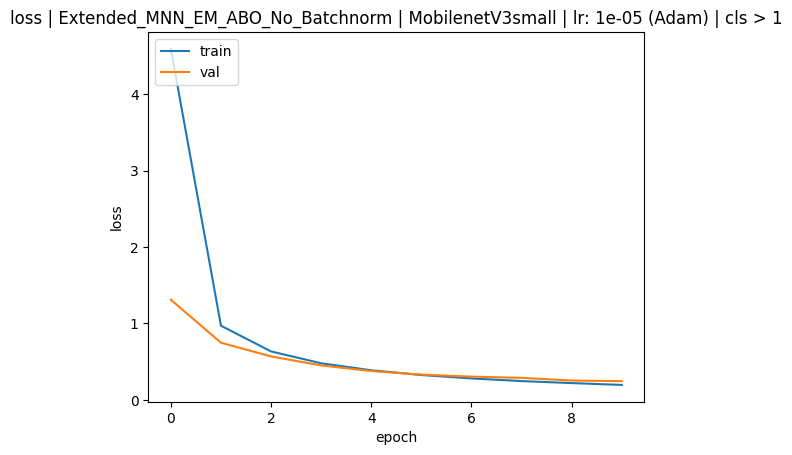

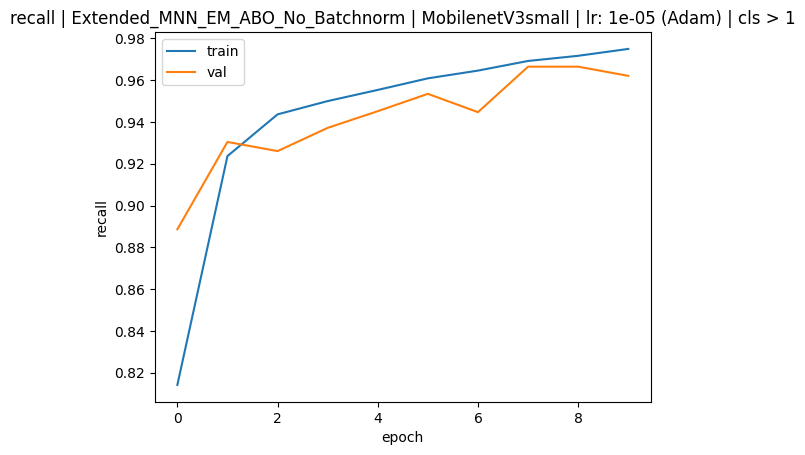

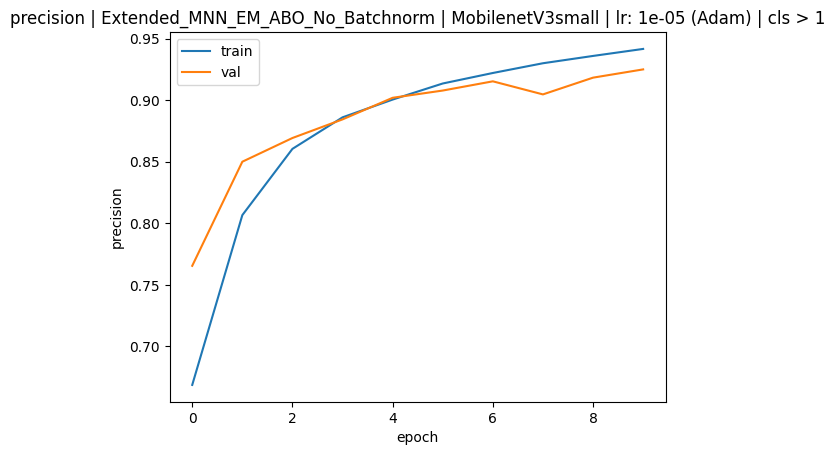

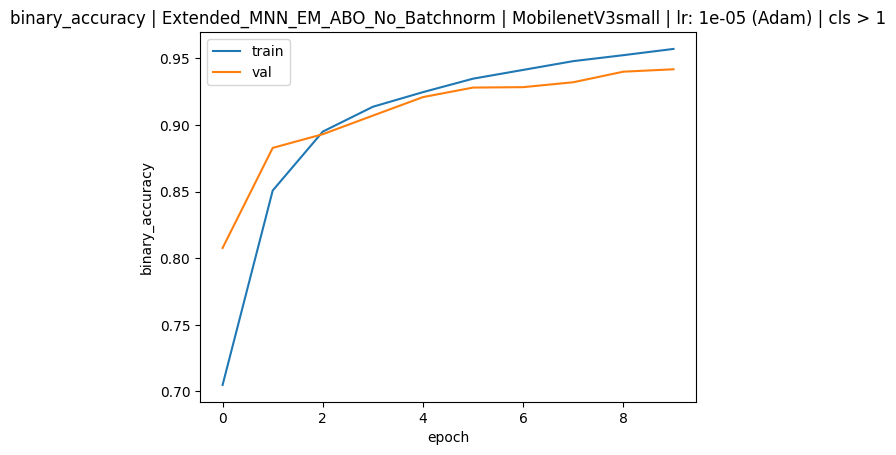

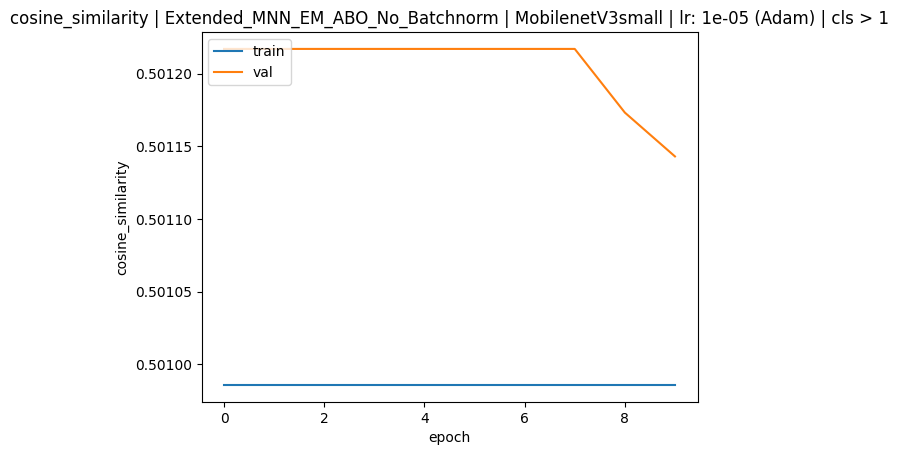

In [71]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [72]:
from utils.metrics import evaluate

In [73]:
evaluate(ext_mnn_em.model, [img_test, text_test, text2_test], labels_test,
         log_dir, model_name, img_model.name, optimizer_name, learning_rate,
         config["data"]["cls"])

14153/14153 [==============================] - 49s 3ms/step - loss: 0.2500 - recall: 0.9609 - precision: 0.9267 - binary_accuracy: 0.9420 - cosine_similarity: 0.5039
